# The Battle of Neighborhoods | NYC Apartments Via Airbnb Data

In this week, you will continue working on your capstone project. Please remember by the end of this week, you will need to submit the following:

A full report consisting of all of the following components (15 marks):

- Introduction where you discuss the business problem and who would be interested in this project.

- Data where you describe the data that will be used to solve the problem and the source of the data.

- Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

- Results section where you discuss the results.

- Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

- Conclusion section where you conclude the report.

2. A link to your Notebook on your Github repository pushed showing your code. (15 marks)

3. Your choice of a presentation or blogpost. (10 marks)

## Business Problem | Introduction

The purpose of this project is to help people find the best apartment rental in Manhattan, NY. It will help people make a smart and efficient decision on selecting the best neighborhood out of a number of other neighborhoods in NYC. 

Lots of people are migrating to different parts of Manhattan and need lots of research for good apartment rental prices, distance to nearby subway stations, and distance to popular tourist attractions. This project is for those people who are looking for better neighborhoods.

This project aim to create an analysis of features for people migrating to Manhattan to search the best neighborhood as a comparative analysis between neighborhoods. The features include median housing price and better school according to accomodation prices with fees, location of the accomodation, venues within a radius of 1000 meters from the accomodation, and crime rate data in radius of 100 meters from the accomodation.

It will help people to get awareness of the area and neighborhood before moving to a new city for their work or to start a new fresh life.

## Data
For our investigation we will use the free and public available datasets.
We will try to evaluate available Airbnb 2020-year accommodations on Manhattan, New York and define the most reasonable apartments sets(clusters) for the visitors.

Based on definition of our problem, we suppose that factors that will help us are:

accommodation prices average by neighborhood;
number of tourist attractions near the accommodation;
number of crimes nearby the accommodation.
Following data sources is needed for our project:

New York City apartment listing from the Inside Airbnb site - 
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz

New York Neighborhoods Tabulation Areas - 
https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON

Foursquare API to extract data about venues - food places, museums, galleries, shopping centers, sightseeing attractions, etc.

New York Crime data for 2020 year - https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD

New York City Subway Stations - https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=GeoJSON

In [1]:
import pandas as pd
import locale
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
import matplotlib.path as mpltPath

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [26]:
# !pip install folium
import folium
from folium import plugins

## Neighborhood Tabulation Areas

In [5]:
# Read the same file from IBM COS
!wget -q -O 'Neighborhood Tabulation Areas.geojson' https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/Neighborhood%20Tabulation%20Areas%20Manhattan.geojson 'Neighborhood Tabulation Areas.geojson'
print('Data downloaded!')
newyork_data_filename = 'Neighborhood Tabulation Areas.geojson'

Data downloaded!


In [6]:
with open(newyork_data_filename) as json_data:
    newyork_data = json.load(json_data)

In [7]:
# Create New York Area Tabulation Data Polygons
neighborhoods_polygons = {}
for neighborhood in newyork_data['features']:
    name = neighborhood['properties']['ntaname']
    neighborhoods_polygons[name] = neighborhood['geometry']

In [8]:
# Function to define NYC Tab Area by latitude, longitude
def define_tab_area(latitude, longitude):
    point = [[longitude,latitude]]
    for k,v in neighborhoods_polygons.items():                
        polygon_shapes = v['coordinates']      
        if len(polygon_shapes) == 1:
            path = mpltPath.Path(polygon_shapes[0][0])
            if path.contains_points(point):
                return k
        else:
            for p in polygon_shapes:
                path = mpltPath.Path(p[0])
                if path.contains_points(point):
                    return k        
    return 'Not defined'
        
define_tab_area(40.72290,-73.98199)

'Lower East Side'

In [9]:
# Neighborhood Tabulation Areas.geojson file contains only polygon area cordinates for each Neighborhoods
# So we need to define a Centroid point's 'latitude', 'longitude' for each Manhattan's Neighborhoods
# We re-calculated it, made some manual correction because Nominatim service is not quite accurate and stored in NYC_Neiborhood_Lat_Lon_Man.csv in IBM COS
for i in range(len(newyork_data['features']) -1, -1, -1):
    if newyork_data['features'][i]["properties"]["boro_name"] != 'Manhattan':
        del newyork_data['features'][i]      

from  geopy.geocoders import Nominatim
import time
neighborhoods_data = newyork_data['features']
data = []
geolocator = Nominatim(user_agent="courseracapstone")
for n in neighborhoods_data:
    city_split =n['properties']['ntaname'].split('-')[0]
    city =n['properties']['ntaname']
    print(city_split)
    if city_split == 'SoHo':
        city_split = 'Soho'
    if city_split == 'Battery Park City':
        city_split = 'Wall Street'   
    if city_split == 'Clinton':
        city_split = "Hell's Kitchen"   
    if city_split == 'Central Harlem North':
        city_split = "Harlem North"
    if city_split == 'Central Harlem South':
        city_split = "Harlem South"                        
        
    loc = geolocator.geocode(city_split + ", New York")    
    print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)
    data.append([city,loc.latitude,loc.longitude])  
    time.sleep(1)

neighborhoods_geo = pd.DataFrame(data, columns = ['Neighborhood', 'Latitude', 'Longitude'])
neighborhoods_geo

Manhattanville
latitude is :- 40.8157775 
longtitude is:- -73.951554
Clinton
latitude is :- 40.7644228 
longtitude is:- -73.9923918
Chinatown
latitude is :- 40.7164913 
longtitude is:- -73.9962504
Battery Park City
latitude is :- 40.7060194 
longtitude is:- -74.0088308
Lincoln Square
latitude is :- 40.7723194 
longtitude is:- -73.9844012
Midtown
latitude is :- 40.7587979 
longtitude is:- -73.9623427
Upper East Side
latitude is :- 40.7737016 
longtitude is:- -73.9641196
Central Harlem North
latitude is :- 40.8078786 
longtitude is:- -73.9454154
Yorkville
latitude is :- 40.7780067 
longtitude is:- -73.9482022
East Village
latitude is :- 40.7292688 
longtitude is:- -73.9873613
Lower East Side
latitude is :- 40.7159357 
longtitude is:- -73.9868057
Gramercy
latitude is :- 40.7355189 
longtitude is:- -73.9840794
Marble Hill
latitude is :- 40.8762983 
longtitude is:- -73.9104292
SoHo
latitude is :- 40.72288 
longtitude is:- -73.9987505
West Village
latitude is :- 40.7341857 
longtitude is:- -

,Neighborhood,Latitude,Longitude
0,Manhattanville,40.815778,-73.951554
1,Clinton,40.764423,-73.992392
2,Chinatown,40.716491,-73.996250
3,Battery Park City-Lower Manhattan,40.706019,-74.008831
4,Lincoln Square,40.772319,-73.984401
5,Midtown-Midtown South,40.758798,-73.962343
6,Upper East Side-Carnegie Hill,40.773702,-73.964120
7,Central Harlem North-Polo Grounds,40.807879,-73.945415
8,Yorkville,40.778007,-73.948202
9,East Village,40.729269,-73.987361


In [10]:
#  Read pre-calculated NYC_Neiborhood_Lat_Lon_Man.csv Centroids from IBM COS
neighborhoods_geo = pd.read_csv('https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/NYC_Neiborhood_Lat_Lon_Man.csv')
neighborhoods_geo.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude
0,0,Manhattanville,40.815778,-73.951554
1,1,Clinton,40.764423,-73.992392
2,2,Chinatown,40.715100,-73.995500
3,3,Battery Park City-Lower Manhattan,40.706784,-74.010147
4,4,Lincoln Square,40.772319,-73.984401


In [11]:
neighborhoods_geo.tail()

,Unnamed: 0,Neighborhood,Latitude,Longitude
24,24,Turtle Bay-East Midtown,40.753467,-73.968866
25,25,Lenox Hill-Roosevelt Island,40.766437,-73.959017
26,26,park-cemetery-etc-Manhattan,40.871600,-73.925300
27,27,Central Harlem South,40.802900,-73.952300
28,28,East Harlem North,40.801100,-73.936100


## Airbnb

In [12]:

# We read already extracted file from IBM COS
df= pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv', parse_dates=['last_scraped', 'last_review'])
df.shape

(44666, 74)

In [13]:
df.dtypes

id                                              int64         
listing_url                                     object        
scrape_id                                       int64         
last_scraped                                    datetime64[ns]
name                                            object        
description                                     object        
neighborhood_overview                           object        
picture_url                                     object        
host_id                                         int64         
host_url                                        object        
host_name                                       object        
host_since                                      object        
host_location                                   object        
host_about                                      object        
host_response_time                              object        
host_response_rate                              object 

In [14]:
df.tail()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
44661,45724439,https://www.airbnb.com/rooms/45724439,20201005145859,2020-10-11,Clean Upper East Side Room for Women,"The unit is located on the 3rd floor in Lennox Hill (Upper East Side of Manhattan). <br /><br />Your room has a full-sized bed with a clothing rack and vanity/desk space. There are 2 large windows that let in sunlight. <br /><br />You'll have access to the living room and kitchen areas. There is one full bathroom to share. Wifi and AC are also available. <br /><br />Subway stations (Q train), restaurants, markets, delis, bars, banks, cafes, and parks are all within a few min walk. <br /><br />Pets are welcome (under 15 pounds)",NaN,https://a0.muscache.com/pictures/85006154-abb9-4e34-b7fa-e29d2123f9a4.jpg,120449763,https://www.airbnb.com/users/show/120449763,Tamara,2017-03-12,"Los Angeles, California, United States",NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/fd0064c4-a11f-4f13-97de-5a1c8596078d.jpg?aki_policy=profile_small,https://a0.muscache.com/im/pictures/user/fd0064c4-a11f-4f13-97de-5a1c8596078d.jpg?aki_policy=profile_x_medium,NaN,0.0,0.0,"['email', 'phone', 'facebook', 'offline_government_id', 'government_id']",t,t,NaN,Upper East Side,Manhattan,40.76640,-73.95283,Private room in apartment,Private room,1,NaN,1 shared bath,1.0,0.0,"[""Laptop-friendly workspace"", ""Air conditioning"", ""Lock on bedroom door"", ""Wifi"", ""Heating"", ""Smoke alarm"", ""Essentials"", ""Kitchen"", ""TV"", ""Private living room""]",$50.00,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,2020-10-11,0,0,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
44662,45725790,https://www.airbnb.com/rooms/45725790,20201005145859,2020-10-07,Idyllic Birds Eye View Escape in the LES,NaN,NaN,https://a0.muscache.com/pictures/2f68308a-dea8-4191-82dd-904e6984266d.jpg,7614437,https://www.airbnb.com/users/show/7614437,Marissa,2013-07-20,"New York, New York, United States",I am the CEO and Founder/Producer at Mythologie Pictures.,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/14f3a8e1-5fdd-4fa4-8735-f945366993af.jpg?aki_policy=profile_small,https://a0.muscache.com/im/pictures/user/14f3a8e1-5fdd-4fa4-8735-f945366993af.jpg?aki_policy=profile_x_medium,NaN,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jumio', 'offline_government_id', 'government_id', 'work_email']",t,t,NaN,Lower East Side,Manhattan,40.71588,-73.98741,Entire apartment,Entire home/apt,4,NaN,1 bath,2.0,4.0,"[""Wifi"", ""Dryer"", ""Hangers"", ""Air conditioning"", ""Kitchen"", ""Hot water"", ""Smoke alarm"", ""Carbon monoxide alarm"", ""Washer"", ""Laptop-friendly workspace"", ""TV"", ""Elevator"", ""Essentials"", ""Heating""]",$200.00,

Airbnb dataframe for Manhattan from 2020 has 44,666 rows and 74 columns. Records were filtered by:
- Borough (Manhattan NY)
- Number of reviews >= 10
- Availability >= 10 days/year
- Last scraped later 10/7/2020
- Minimum nights >= 1
- Excluded Hostels and Camper/RV
- Excluded shared rooms

In [15]:
# Filter Accomodations 
df_filter = df[(df.neighbourhood_group_cleansed == 'Manhattan')
               & (df.number_of_reviews >= 10) 
               & (df.availability_365 >= 10)
               & (df.last_scraped > '2020-01-01')
               & (df.last_review > '2020-01-01')
               & (~df.room_type.isin(['Shared room']))
               & (~df.property_type.isin(['Camper/RV', 'Hostel']))
               & (df.minimum_nights < 3 )
              ].copy()
df_filter.shape

(1228, 74)

In [16]:
df_filter.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
4,5178,https://www.airbnb.com/rooms/5178,20201005145859,2020-10-07,Large Furnished Room Near B'way,"Please don’t expect the luxury here just a basic room in the center of Manhattan.<br /><br /><b>The space</b><br />You will use one large, furnished, private room of a two-bedroom apartment and share a bathroom with the host. <br /><br />The apartment is located a few blocks away from Central Park between 8th and 9th Avenue.<br />The closest subway station is Columbus Circle 59th Street. Great restaurants, Broadway and all transportation are easily accessible. <br /><br />The cost of the room is $79 per night. Weekly rate is available.<br />There is a $12.00 fee per guest. <br /><br />The apartment also features hardwood floors and a second-floor walk-up. <br />There is a full-sized bed,TV, microwave, and a small refrigerator as well as other appliances. <br />Wired internet, WIFI, TV, electric heat, bed sheets and towels are included. <br /><br />A kitchen is not available in the living room. Please ask the host if you need.<br /><br />Basic check in/out time is 10 am. I am flexib","Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997b_original.jpg,8967,https://www.airbnb.com/users/show/8967,Shunichi,2009-03-03,"New York, New York, United States",I used to work for a financial industry but now I work at a Japanese food market as an assistant manager.,within a few hours,100%,100%,f,https://a0.muscache.com/im/users/8967/profile_pic/1265419894/original.jpg?aki_policy=profile_small,https://a0.muscache.com/im/users/8967/profile_pic/1265419894/original.jpg?aki_policy=profile_x_medium,Hell's Kitchen,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"New York, United States",Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room in apartment,Private room,2,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Paid parking off premises"", ""Luggage dropoff allowed"", ""Lock on bedroom door"", ""Extra pillows and blankets"", ""Smoke alarm"", ""Microwave"", ""Shampoo"", ""Refrigerator"", ""TV"", ""Bed linens"", ""Iron"", ""Hair dryer"", ""Free street parking"", ""Essentials"", ""Heating""]",$73.00,2,14,2.0,2.0,14.0,14.0,2.0,14.0,NaN,t,29,53,78,350,2020-10-07,473,25,0,2009-05-06,2020-03-15,84.0,9.0,7.0,9.0,9.0,10.0,9.0,NaN,f,1,0,1,0,3.40
17,9704,https://www.airbnb.com/rooms/9704,20201005145859,2020-10-07,Spacious 1 bedroom in luxe building,"The room is spacious, the neighborhood is safe, and you are 10 blocks north of Central Park. The Subway is a 4 minute walk with Express and Local trains. Plenty of restaurants, bars and cafes nearby.<br /><br />The room has a desk and chair. Sorry

In [17]:
# Select subset of the original columns
# Clean the data
# Convert Price strings into Float
# Change some Strings Columns into Numeric
airbnb = df_filter[['id',  'name', 'last_review', 'listing_url', 'picture_url', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'review_scores_rating',             
             'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
              'price','minimum_nights', 'number_of_reviews_ltm', 'reviews_per_month',
             'number_of_reviews', 'availability_365']].copy()
airbnb['price'].fillna('$0', inplace=True)
airbnb.fillna('0', inplace=True)
airbnb= airbnb.astype({'bathrooms':'int','bedrooms':'int'})
airbnb['price'] = airbnb['price'].apply(lambda x: locale.atof(x.strip("$")))
airbnb.shape

(1228, 21)

In [32]:
# Add new feature - price per person
airbnb['price_per_person'] =  (airbnb['price'])/airbnb['accommodates']

In [33]:
# Add tab_area column using define_tab_area function from neighborhoods_geo df
airbnb['tab_area'] =  airbnb.apply(lambda row : define_tab_area(row['latitude'], row['longitude']), axis = 1) 
airbnb.head()


,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,price,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365,tab_area,price_per_person
4,5178,Large Furnished Room Near B'way,2020-03-15,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/pictures/12065/f070997b_original.jpg,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Private room in apartment,Private room,2,0,1,73.00,2,25,3.40,473,350,Clinton,36.50
17,9704,Spacious 1 bedroom in luxe building,2020-03-14,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/pictures/38418/569b54fd_original.jpg,Manhattan,Harlem,98.0,40.81305,-73.95466,Private room in apartment,Private room,2,0,1,55.00,2,3,1.27,98,365,Manhattanville,27.50
21,12192,ENJOY Downtown NYC!,2020-03-17,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/pictures/93658190/67480448_original.jpg,Manhattan,East Village,88.0,40.72290,-73.98199,Private room in apartment,Private room,2,0,1,30.00,2,7,1.97,262,293,Lower East Side,15.00
36,15220,Best Location in NYC! TIMES SQUARE!,2020-07-19,https://www.airbnb.com/rooms/15220,https://a0.muscache.com/pictures/4e5f84c3-ec0b-4f7d-8a95-91553c2407a3.jpg,Manhattan,Hell's Kitchen,93.0,40.75531,-73.99293,Private room in apartment,Private room,1,0,1,96.71,2,20,2.48,325,364,Clinton,96.71
40,15711,2 bedroom Upper East Side,2020-07-08,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg,Manhattan,Upper East Side,94.0,40.77065,-73.95269,Entire apartment,Entire home/apt,6,0,2,219.00,2,13,0.63,83,54,Lenox Hill-Roosevelt Island,36.50


### Outliers in Airbnb Dataframe

Text(0.5, 0.98, '')

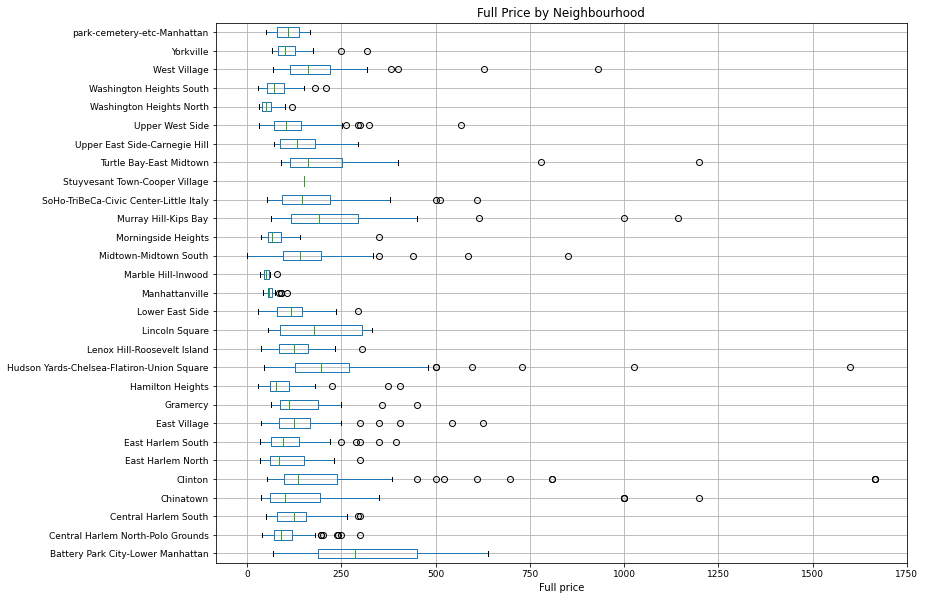

In [34]:
#Check for outliers
bp = airbnb[['tab_area','price']].boxplot(column='price', by='tab_area',vert=False, fontsize=9, figsize=(12,10) )
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

In [35]:
#Remove outliers
Q1 = airbnb['price'].quantile(0.25)
Q3 = airbnb['price'].quantile(0.75)
IQR = Q3 - Q1

filter = (airbnb['price'] >= Q1 - 1.5 * IQR) & (airbnb['price'] <= Q3 + 1.5 *IQR)
airbnb_norm = airbnb.loc[filter]  
airbnb_norm.shape

(1165, 23)

Text(0.5, 0.98, '')

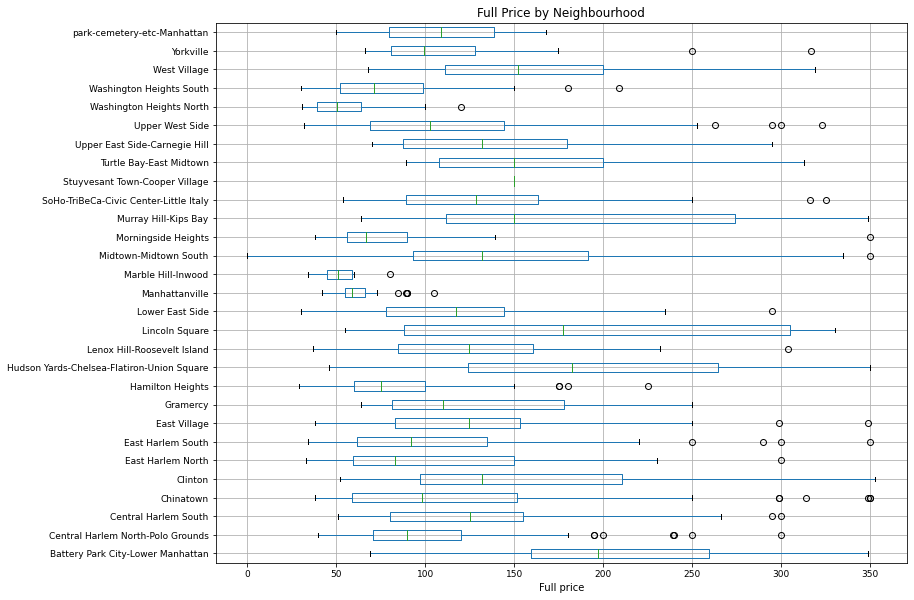

In [36]:
bp = airbnb_norm[['tab_area','price']].boxplot(column='price', by='tab_area',vert=False, fontsize=9, figsize=(12,10))
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

## Methodology


In this project we are trying to detect Manhattan's Neighborhoods that have accommodations for rent with positive reviews, reasonable prices, low number of crimes and tourists' attractions nearby.

In the first step we have collected the following data:

- Airbnb Accommodations with their NYC Tabulation Area (official neighborhood names);

The second step in our analysis will be a calculation and exploration different neighborhoods of Manhattan. We will explore the following characteristics:

- average price per person;
- number of accommodations available.

In third and final step we will

- select Top-100 Airbnb accommodations based on summary rating, number of crimes and price per person, and
- invoke Foursquare API to find Top accommodations' nearby venues
- create and investigate clusters (using k-means clustering) for our accommodations to make some recommendations to our tourists.

## Analysis

In [37]:
airbnb_norm.head()

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,price,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365,tab_area,price_per_person
4,5178,Large Furnished Room Near B'way,2020-03-15,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/pictures/12065/f070997b_original.jpg,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Private room in apartment,Private room,2,0,1,73.00,2,25,3.40,473,350,Clinton,36.50
17,9704,Spacious 1 bedroom in luxe building,2020-03-14,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/pictures/38418/569b54fd_original.jpg,Manhattan,Harlem,98.0,40.81305,-73.95466,Private room in apartment,Private room,2,0,1,55.00,2,3,1.27,98,365,Manhattanville,27.50
21,12192,ENJOY Downtown NYC!,2020-03-17,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/pictures/93658190/67480448_original.jpg,Manhattan,East Village,88.0,40.72290,-73.98199,Private room in apartment,Private room,2,0,1,30.00,2,7,1.97,262,293,Lower East Side,15.00
36,15220,Best Location in NYC! TIMES SQUARE!,2020-07-19,https://www.airbnb.com/rooms/15220,https://a0.muscache.com/pictures/4e5f84c3-ec0b-4f7d-8a95-91553c2407a3.jpg,Manhattan,Hell's Kitchen,93.0,40.75531,-73.99293,Private room in apartment,Private room,1,0,1,96.71,2,20,2.48,325,364,Clinton,96.71
40,15711,2 bedroom Upper East Side,2020-07-08,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg,Manhattan,Upper East Side,94.0,40.77065,-73.95269,Entire apartment,Entire home/apt,6,0,2,219.00,2,13,0.63,83,54,Lenox Hill-Roosevelt Island,36.50


In [38]:
# Calculate average price_per_person and number of accomodations for each Airbnb neighborhood
neighbourhood_price_merged = airbnb_norm.copy()
neighbourhood_price_merged = neighbourhood_price_merged.groupby("tab_area", as_index=False).agg({ 'price_per_person':'mean', 'accommodates':'count'})
neighbourhood_price_merged.columns=['tab_area', 'mean_price_per_person', 'accommodates']

In [39]:
#
neighbourhood_price_merged[['tab_area', 'mean_price_per_person', 'accommodates']].sort_values('mean_price_per_person')

,tab_area,mean_price_per_person,accommodates
24,Washington Heights North,30.536458,16
15,Marble Hill-Inwood,35.907000,10
25,Washington Heights South,36.007439,37
9,Hamilton Heights,37.985476,63
14,Manhattanville,38.079295,26
1,Central Harlem North-Polo Grounds,39.012662,66
6,East Harlem South,40.408559,37
17,Morningside Heights,42.310000,30
27,Yorkville,43.571969,26
5,East Harlem North,44.009208,40


Top five neighborhoods with HIGHEST price per person 
- Hudson Yards-Chelsea-Flatiron-Union Square : 76.20USD : 78 accomodations
- Stuy Town-Cooper Village : 75 USD : 1 accommodation
- West Village : 72.79 USD : 45 accommodations
- Lincoln Square : 72.38 USD : 16 accommodations
- Battery Park - Lower Manhattan : 67.78 USD : 15 accommodations

Top five neighborhoods with LOWEST price per person 
- Washington Heights North: 30.54 USD : 16 accommodations 
- Marble Hill - Inwood: 35.91 USD : 10 accommodations
- Washington Heights South: 36 USD : 37 accommodations
- Hamilton Heights: 37.99 USD : 63 accommodations
- Manhattanville: 38.08 USD : 26 accommodations

## Foursquare API Neighborhood Accomodations

In [45]:
limit=100
airbnb_top = airbnb_norm.sort_values(by=['review_scores_rating',  'price','price_per_person'], ascending=[False, True, True])[['name', 'tab_area', 'neighbourhood_cleansed','latitude', 'longitude' ,'review_scores_rating',  'property_type', 'room_type', 'accommodates', 'price', 'price_per_person','listing_url','picture_url','bathrooms', 'bedrooms']].head(limit)


In [46]:
airbnb_top.head()

,name,tab_area,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,price,price_per_person,listing_url,picture_url,bathrooms,bedrooms
37101,Stylish Private Bedroom,Morningside Heights,Morningside Heights,40.81204,-73.95856,100.0,Private room in apartment,Private room,2,38.0,19.0,https://www.airbnb.com/rooms/39951152,https://a0.muscache.com/pictures/7bbd3972-cc04-4557-b6aa-bb644fe60525.jpg,0,1
41422,Cozy and private bedroom in Manhattan.,Manhattanville,Harlem,40.82124,-73.95479,100.0,Private room in apartment,Private room,2,42.0,21.0,https://www.airbnb.com/rooms/43300250,https://a0.muscache.com/pictures/b0d50da8-2c25-43a1-a014-aedfa1a2d269.jpg,0,1
30465,Friendly relaxing place for you to stay,Washington Heights South,Washington Heights,40.84389,-73.93688,100.0,Private room in apartment,Private room,2,46.0,23.0,https://www.airbnb.com/rooms/32638774,https://a0.muscache.com/pictures/503bd943-5839-4866-b221-6dfd661f52b1.jpg,0,1
40634,UES - Manhattan Cozy Room/ Elevator Building,Lenox Hill-Roosevelt Island,Upper East Side,40.77116,-73.95644,100.0,Private room in apartment,Private room,2,46.0,23.0,https://www.airbnb.com/rooms/42763301,https://a0.muscache.com/pictures/2765f4b5-434e-440a-9a8b-d87210b52ec8.jpg,0,1
38064,Private Room in Harlem- for solo traveler,Manhattanville,Harlem,40.81566,-73.95405,100.0,Private room in apartment,Private room,1,58.0,58.0,https://www.airbnb.com/rooms/40673058,https://a0.muscache.com/pictures/a7373f2d-0821-4d8c-be76-71c79beb8d14.jpg,0,1


In [47]:
CLIENT_ID = 'WG3CUHL5JFNNC2VQINFL2STISC4A4M0PZIK0CJXFORT2LBG1' # your Foursquare ID
CLIENT_SECRET = 'KIU2IIOL2I1A2M4V1TNIGOEL0ME310AWVKGVHZC0EXX1XGHM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50
RADIUS = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WG3CUHL5JFNNC2VQINFL2STISC4A4M0PZIK0CJXFORT2LBG1
CLIENT_SECRET:KIU2IIOL2I1A2M4V1TNIGOEL0ME310AWVKGVHZC0EXX1XGHM


In [48]:
def getAccomodatesNearbyVenues(names, latitudes, longitudes, radius, limit):
    venues_list=[]
    nearby_venues = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        try:
            response = requests.get(url)
            if response.status_code == 200: 
                results = response.json()["response"]['groups'][0]['items']
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])

                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['name', 
                                         'latitude', 
                                         'longitude', 
                                         'Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']
            else:
                print ("Exception during call URL={} , Code={}, Text={}".format(url, response.status_code, response.text))
        except Exception as e:
            print ("Exception: {}".format(e))
            raise e
    
    return(nearby_venues)

In [49]:
airbnb_top_venues = getAccomodatesNearbyVenues(names=airbnb_top['name'],
                                   latitudes=airbnb_top['latitude'],
                                   longitudes=airbnb_top['longitude'],
                                   radius = RADIUS,
                                   limit = LIMIT
                                  )

Stylish Private Bedroom
Cozy and private bedroom in Manhattan.
Friendly relaxing place for you to stay
UES - Manhattan Cozy Room/ Elevator Building
Private Room in Harlem- for solo traveler
Harlem Cool Kid Collective
Cozy Private Room next to Central Park!
Stylish Modern Uptown Apt | Steps from the subway!
Aesthetically Designed Modern Private Room
Large, Comfy & Clean Room for 3 w/ TV near Subway!
Rent a room with amazing Hudson view
Charming and Comfortable Room in Manhattan
Cozy, Private Bedroom Near Central Park
Bright and Clean Manhattan Apartment
Peaceful Queen Bedroom on UES
Midtown Spacious Room Private Bath (Self Check-In)
UNIQUE 30 FL VIEWS LUX HUGE  PRIVATE  SANITIZED!
Peaceful Green House
Art filled peaceful paradise EV Union Square
Prvt Room for 4-Near Columbia Uni. With Breakfast!
Private room in the WV 3rd floor
Central Park Nest, High Above The Trees!
East Village- The location
Retreat to a Serene Hotel Quality Stay in the City
STERILE FlatIron bedroom in a 2000 sqft lo

In [50]:
airbnb_top_venues.head()


,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stylish Private Bedroom,40.81204,-73.95856,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant
1,Stylish Private Bedroom,40.81204,-73.95856,Sakura Park,40.813078,-73.962124,Park
2,Stylish Private Bedroom,40.81204,-73.95856,Levels Barbershop,40.812058,-73.955157,Salon / Barbershop
3,Stylish Private Bedroom,40.81204,-73.95856,Oasis Juice Bar,40.815017,-73.958879,Juice Bar
4,Stylish Private Bedroom,40.81204,-73.95856,Morningside Playground,40.810073,-73.955823,Playground


In [51]:
airbnb_top_venues.shape


(5000, 7)

In [52]:
# Define categories from Foursquares
fine_art = ['Art','Arts','Museum', 'Library','Exhibit','Gallery']
eateries = ['Restaurant','Steakhouse']
shopping = ['Shopping Mall','Market','Boutique']
outdoor = ['Sculpture Garden','Scenic Lookout','Roof Deck','Outdoor Sculpture','Monument / Landmark',
               'Memorial Site','Lighthouse','Historic Site','Harbor / Marina','Fountain','Event Space','Bridge',
               'Waterfront','Church','Building','Garden','Historic Site','Lake','Park',
               'Pier','Rest Area','River','Synagogue','Field']
entertainment = ['Nightclub','Circus','Club', 'Stadium', 'Karaoke Bar', 'Pub','Theater','Opera', 'Concert', 'Zoo']

#Join all categories' values in one
tourists_categories = fine_art + eateries + shopping + outdoor +entertainment

In [53]:
def check(category):
    if any(word in category for word in tourists_categories):
        return True
    return False

In [54]:
# Define Venue's Category
def change_category(name):
    if any(word in name for word in entertainment):
        return 'Entertainment'
    if any(word in name for word in fine_art):
        return 'Fine Art'
    if any(word in name for word in eateries):
        return 'Food Place'
    if any(word in name for word in shopping):        
        return 'Shopping'
    if any(word in name for word in outdoor):            
        return 'Sightseeing'
    if any(word in name for word in tansportation):            
        return 'Transportation'

In [55]:
# Define Top Venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:num_top_venues] 

def return_most_common_venues_stats(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:num_top_venues]

In [56]:
airbnb_top_venues_f = airbnb_top_venues[airbnb_top_venues['Venue Category'].apply(lambda x: check(x))].copy()
airbnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stylish Private Bedroom,40.81204,-73.95856,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant
1,Stylish Private Bedroom,40.81204,-73.95856,Sakura Park,40.813078,-73.962124,Park
5,Stylish Private Bedroom,40.81204,-73.95856,Max SoHa,40.811241,-73.957869,Italian Restaurant
7,Stylish Private Bedroom,40.81204,-73.95856,El Puerto Seafood and Fish Market,40.813861,-73.956737,Seafood Restaurant
9,Stylish Private Bedroom,40.81204,-73.95856,Jin Ramen,40.815406,-73.958547,Ramen Restaurant


In [57]:
# Add Venue Category column
airbnb_top_venues_f.rename(columns = {'Venue Category':'Venue Type'}, inplace = True)

In [58]:
airbnb_top_venues_f['Venue Category'] = airbnb_top_venues_f['Venue Type'].apply(lambda x: change_category(x))
airbnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Type,Venue Category
0,Stylish Private Bedroom,40.81204,-73.95856,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,Food Place
1,Stylish Private Bedroom,40.81204,-73.95856,Sakura Park,40.813078,-73.962124,Park,Sightseeing
5,Stylish Private Bedroom,40.81204,-73.95856,Max SoHa,40.811241,-73.957869,Italian Restaurant,Food Place
7,Stylish Private Bedroom,40.81204,-73.95856,El Puerto Seafood and Fish Market,40.813861,-73.956737,Seafood Restaurant,Food Place
9,Stylish Private Bedroom,40.81204,-73.95856,Jin Ramen,40.815406,-73.958547,Ramen Restaurant,Food Place


In [59]:
# Calculate and display top 3 venue categoriesfor each accomodation
# one hot encoding
airbnb_onehot = pd.get_dummies(airbnb_top_venues_f[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
airbnb_onehot['name'] = airbnb_top_venues_f['name'] 

# move name column to the first column
fixed_columns = [airbnb_onehot.columns[-1]] + list(airbnb_onehot.columns[:-1])
airbnb_onehot = airbnb_onehot[fixed_columns]

In [60]:

airbnb_grouped = (np.round(airbnb_onehot.groupby('name').mean(),2)).reset_index()
airbnb_grouped.head()

,name,Entertainment,Fine Art,Food Place,Shopping,Sightseeing
0,1 Bedroom Apartment — Amazing Location in Midtown!,0.07,0.04,0.89,0.00,0.00
1,2-story Apt in the heart of The Upper West Side!,0.04,0.04,0.81,0.04,0.08
2,A Studio Fit for a King,0.53,0.10,0.33,0.00,0.03
3,Aesthetically Designed Modern Private Room,0.05,0.00,0.68,0.00,0.26
4,Art filled peaceful paradise EV Union Square,0.08,0.00,0.77,0.08,0.08


In [61]:
# Find Top-3 Venues Category
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create a new dataframe
airbnb_venues_sorted = pd.DataFrame(columns=columns)
airbnb_venues_sorted['name'] = airbnb_grouped['name']

for ind in np.arange(airbnb_grouped.shape[0]):
    strings_stats = np.around(return_most_common_venues_stats(airbnb_grouped.iloc[ind, :], num_top_venues),2) 
    strings_category = return_most_common_venues(airbnb_grouped.iloc[ind, :], num_top_venues)
    airbnb_venues_sorted.iloc[ind, 1:] = np.concatenate([strings_category,strings_stats ])

airbnb_venues_sorted.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,1 Bedroom Apartment — Amazing Location in Midtown!,Food Place,Entertainment,Fine Art,0.89,0.07,0.04
1,2-story Apt in the heart of The Upper West Side!,Food Place,Sightseeing,Shopping,0.81,0.08,0.04
2,A Studio Fit for a King,Entertainment,Food Place,Fine Art,0.53,0.33,0.1
3,Aesthetically Designed Modern Private Room,Food Place,Sightseeing,Entertainment,0.68,0.26,0.05
4,Art filled peaceful paradise EV Union Square,Food Place,Sightseeing,Shopping,0.77,0.08,0.08


In [62]:
# set number of clusters
kclusters = 3

airbnb_grouped_clustering = airbnb_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(airbnb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 2, 0, 0, 0, 0, 2, 0], dtype=int32)

In [63]:
# add clustering labels
airbnb_venues_clustered = airbnb_venues_sorted.copy()
airbnb_venues_clustered.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,1 Bedroom Apartment — Amazing Location in Midtown!,Food Place,Entertainment,Fine Art,0.89,0.07,0.04
1,2-story Apt in the heart of The Upper West Side!,Food Place,Sightseeing,Shopping,0.81,0.08,0.04
2,A Studio Fit for a King,Entertainment,Food Place,Fine Art,0.53,0.33,0.1
3,Aesthetically Designed Modern Private Room,Food Place,Sightseeing,Entertainment,0.68,0.26,0.05
4,Art filled peaceful paradise EV Union Square,Food Place,Sightseeing,Shopping,0.77,0.08,0.08


In [64]:
airbnb_venues_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
airbnb_venues_clustered.head()

,Cluster Labels,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,0,1 Bedroom Apartment — Amazing Location in Midtown!,Food Place,Entertainment,Fine Art,0.89,0.07,0.04
1,0,2-story Apt in the heart of The Upper West Side!,Food Place,Sightseeing,Shopping,0.81,0.08,0.04
2,1,A Studio Fit for a King,Entertainment,Food Place,Fine Art,0.53,0.33,0.1
3,2,Aesthetically Designed Modern Private Room,Food Place,Sightseeing,Entertainment,0.68,0.26,0.05
4,0,Art filled peaceful paradise EV Union Square,Food Place,Sightseeing,Shopping,0.77,0.08,0.08


In [65]:
airbnb_merged = airbnb_top.copy()
#  add latitude/longitude 
airbnb_merged  = airbnb_merged.join(airbnb_venues_clustered.set_index('name'), on='name')
airbnb_merged = airbnb_merged.dropna()
airbnb_merged.head()

,name,tab_area,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,price,price_per_person,listing_url,picture_url,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
37101,Stylish Private Bedroom,Morningside Heights,Morningside Heights,40.81204,-73.95856,100.0,Private room in apartment,Private room,2,38.0,19.0,https://www.airbnb.com/rooms/39951152,https://a0.muscache.com/pictures/7bbd3972-cc04-4557-b6aa-bb644fe60525.jpg,0,1,2,Food Place,Sightseeing,Entertainment,0.61,0.26,0.13
41422,Cozy and private bedroom in Manhattan.,Manhattanville,Harlem,40.82124,-73.95479,100.0,Private room in apartment,Private room,2,42.0,21.0,https://www.airbnb.com/rooms/43300250,https://a0.muscache.com/pictures/b0d50da8-2c25-43a1-a014-aedfa1a2d269.jpg,0,1,2,Food Place,Sightseeing,Shopping,0.7,0.25,0.05
30465,Friendly relaxing place for you to stay,Washington Heights South,Washington Heights,40.84389,-73.93688,100.0,Private room in apartment,Private room,2,46.0,23.0,https://www.airbnb.com/rooms/32638774,https://a0.muscache.com/pictures/503bd943-5839-4866-b221-6dfd661f52b1.jpg,0,1,0,Food Place,Sightseeing,Shopping,0.76,0.19,0.05
40634,UES - Manhattan Cozy Room/ Elevator Building,Lenox Hill-Roosevelt Island,Upper East Side,40.77116,-73.95644,100.0,Private room in apartment,Private room,2,46.0,23.0,https://www.airbnb.com/rooms/42763301,https://a0.muscache.com/pictures/2765f4b5-434e-440a-9a8b-d87210b52ec8.jpg,0,1,0,Food Place,Sightseeing,Shopping,1,0,0
38064,Private Room in Harlem- for solo traveler,Manhattanville,Harlem,40.81566,-73.95405,100.0,Private room in apartment,Private room,1,58.0,58.0,https://www.airbnb.com/rooms/40673058,https://a0.muscache.com/pictures/a7373f2d-0821-4d8c-be76-71c79beb8d14.jpg,0,1,0,Food Place,Sightseeing,Shopping,0.72,0.12,0.08


In [66]:
#Print NYC Tab Area and airbnb neighborhood names

airbnb_norm.groupby(['tab_area','neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('NYC Tab Area')



,NYC Tab Area,Airbnb Neighbourhood,Count
0,Battery Park City-Lower Manhattan,Financial District,15
1,Central Harlem North-Polo Grounds,East Harlem,10
2,Central Harlem North-Polo Grounds,Harlem,56
3,Central Harlem South,Harlem,47
4,Chinatown,Chinatown,22
5,Chinatown,Lower East Side,33
6,Chinatown,Two Bridges,11
7,Clinton,Hell's Kitchen,131
8,East Harlem North,East Harlem,40
9,East Harlem South,East Harlem,37


In [67]:
# Top airbnb accomodations by nyc tab area names
airbnb_norm.groupby(['tab_area']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area'}).sort_values('Count', ascending = False)


,NYC Tab Area,Count
4,Clinton,131
16,Midtown-Midtown South,94
10,Hudson Yards-Chelsea-Flatiron-Union Square,78
1,Central Harlem North-Polo Grounds,66
3,Chinatown,66
9,Hamilton Heights,63
7,East Village,60
23,Upper West Side,52
2,Central Harlem South,47
26,West Village,45


In [68]:
# Top airbnb accomodation proposals by airbnb neighborhoods
airbnb_norm.groupby(['neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('Count', ascending = False)



,Airbnb Neighbourhood,Count
8,Harlem,193
9,Hell's Kitchen,170
2,East Harlem,87
3,East Village,85
26,Upper West Side,81
25,Upper East Side,76
14,Midtown,68
0,Chelsea,60
27,Washington Heights,51
13,Lower East Side,48


In [72]:
# Create and display clusters
nyc_lat = 40.758896
nyc_lon = -73.985130
map_clusters = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
accomodations_cl = folium.map.FeatureGroup()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, poi, rating, price, price_per_person, accommodates, listing_url, picture_url, bathrooms, bedrooms,neighbourhood_cleansed, cluster in zip(airbnb_merged['latitude'],
                                                                         airbnb_merged['longitude'], 
                                                                         airbnb_merged['name'],
                                                                         airbnb_merged['review_scores_rating'],
                                                                         round(airbnb_merged['price'],2), 
                                                                         round(airbnb_merged['price_per_person'],2), 
                                                                         airbnb_merged['accommodates'],
                                                                         airbnb_merged['listing_url'],
                                                                         airbnb_merged['picture_url'],
                                                                         airbnb_merged['bathrooms'],
                                                                         airbnb_merged['bedrooms'],
                                                                         airbnb_merged['neighbourhood_cleansed'],
                                                                         airbnb_merged['Cluster Labels'].astype(int)):
    html_cl = f"""
     <br /> 
     <b>Cluster: </b>{cluster} <br />  
     <b>Accommodation: </b>{poi} <br />  
     <b>Host: </b><a href='{listing_url}'>{listing_url}</a>  <br />  
     <b>Neighbourhood: </b> {neighbourhood_cleansed}<br />  
     <b>Rating: </b> {rating}<br />  
     <b>Full price (USD): </b>{price}  <br />   
     <b>Price per Person (USD): </b>{price_per_person} <br /> 
     <b>Accommodates: </b>{accommodates}<br /> 
     <b>Bathrooms: </b>{bathrooms}<br /> 
     <b>Bedrooms: </b>{bedrooms}<br /> 
     <img ALIGN="Right" src="{picture_url}" alt="Host picture" width="300"  height="100">
    """
    iframe_cl = folium.IFrame(html=html_cl, width=500, height=350) 
    popup = folium.Popup(iframe_cl, max_width=500)
    accomodations_cl.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=popup,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7
        )
    )     
map_clusters.add_child(accomodations_cl)


Cluster 0 - Mix characteristics:

- average price_per_person
- second top Common Venue Category has a Mix of all kind of Categories
- contains 58% from all top accommodations

In [183]:
# Examine each cluster and determine custom venue categories that distinguish each cluster
cluster0 = airbnb_merged.loc[airbnb_merged['Cluster Labels'] == 0, ~airbnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster0.describe()

,accommodates,price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,45.000000,45.000000,45.000000,45.000000,45.0,45.000000,45.0
mean,2.133333,97.238222,49.192815,45.488889,0.0,1.000000,0.0
std,1.057441,53.253787,22.152705,29.897265,0.0,0.301511,0.0
min,1.000000,30.000000,19.000000,8.000000,0.0,0.000000,0.0
25%,2.000000,60.290000,30.000000,25.000000,0.0,1.000000,0.0
50%,2.000000,80.000000,40.715000,38.000000,0.0,1.000000,0.0
75%,2.000000,135.000000,67.500000,49.000000,0.0,1.000000,0.0
max,6.000000,300.000000,110.000000,138.000000,0.0,2.000000,0.0


In [184]:
cluster0

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
37101,Stylish Private Bedroom,Morningside Heights,Morningside Heights,100,Private room in apartment,Private room,2,38.00,19.000000,28,0,1,0,Food Place,Sightseeing,Entertainment,0.61,0.26,0.13
41422,Cozy and private bedroom in Manhattan.,Manhattanville,Harlem,100,Private room in apartment,Private room,2,42.00,21.000000,99,0,1,0,Food Place,Sightseeing,Shopping,0.7,0.25,0.05
30465,Friendly relaxing place for you to stay,Washington Heights South,Washington Heights,100,Private room in apartment,Private room,2,46.00,23.000000,71,0,1,0,Food Place,Sightseeing,Shopping,0.76,0.19,0.05
30426,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,100,Private room in apartment,Private room,1,50.00,50.000000,45,0,1,0,Food Place,Sightseeing,Shopping,0.75,0.2,0.05
38064,Private Room in Harlem- for solo traveler,Manhattanville,Harlem,100,Private room in apartment,Private room,1,58.00,58.000000,44,0,1,0,Food Place,Sightseeing,Shopping,0.72,0.12,0.08
3124,Harlem Cool Kid Collective,Hamilton Heights,Harlem,100,Private room in apartment,Private room,2,60.00,30.000000,8,0,1,0,Food Place,Sightseeing,Shopping,0.71,0.29,0
38918,Cozy Private Room next to Central Park!,Morningside Heights,Upper West Side,100,Private room in apartment,Private room,2,60.00,30.000000,33,0,1,0,Food Place,Sightseeing,Shopping,0.6,0.32,0.04
40685,Stylish Modern Uptown Apt | Steps from the subway!,Washington Heights South,Washington Heights,100,Private room in apartment,Private room,2,60.00,30.000000,33,0,1,0,Food Place,Sightseeing,Fine Art,0.57,0.24,0.14
26183,Aesthetically Designed Modern Private Room,Manhattanville,Harlem,100,Private room in apartment,Private room,2,60.29,30.145000,37,0,1,0,Food Place,Sightseeing,Entertainment,0.68,0.26,0.05
35016,"Large, Comfy & Clean Room for 3 w/ TV near Subway!",Hamilton Heights,Harlem,100,Private room in apartment,Private room,3,65.00,21.666667,34,0,1,0,Food Place,Sightseeing,Fine Art,0.72,0.16,0.08


In [185]:
sorted(cluster0.tab_area.unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'East Harlem South',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Manhattanville',
 'Marble Hill-Inwood',
 'Morningside Heights',
 'Turtle Bay-East Midtown',
 'Upper West Side',
 'Washington Heights South',
 'Yorkville']

In [186]:
sorted(cluster0.neighbourhood_cleansed.unique())


['Chelsea',
 'East Harlem',
 'Financial District',
 'Gramercy',
 'Harlem',
 'Inwood',
 'Midtown',
 'Morningside Heights',
 'Roosevelt Island',
 'Upper East Side',
 'Upper West Side',
 'Washington Heights']

In [202]:
cluster0.groupby('neighbourhood_cleansed').describe()

accommodates                                            \
                              count      mean       std  min   25%  50%   75%   
neighbourhood_cleansed                                                          
Chelsea                 2.0          3.500000  2.121320  2.0  2.75  3.5  4.25   
East Harlem             5.0          1.800000  0.447214  1.0  2.00  2.0  2.00   
Financial District      1.0          2.000000 NaN        2.0  2.00  2.0  2.00   
Gramercy                2.0          1.500000  0.707107  1.0  1.25  1.5  1.75   
Harlem                  19.0         2.000000  0.745356  1.0  2.00  2.0  2.00   
Inwood                  1.0          2.000000 NaN        2.0  2.00  2.0  2.00   
Midtown                 2.0          3.500000  0.707107  3.0  3.25  3.5  3.75   
Morningside Heights     2.0          2.000000  0.000000  2.0  2.00  2.0  2.00   
Roosevelt Island        1.0          1.000000 NaN        1.0  1.00  1.0  1.00   
Upper East Side         2.0          1.500000  0.707107  1.0  1.25  1.5  1.75   
Upper West Side         2.0          3.000000  1.414214  2.0  2.50  3.0  3.50   
Washington Heights      6.0          2.333333  1.861899  1.0  1.25  2.0  2.00   

                            price                                          \
                        max count        mean         std    min      25%   
neighbourhood_cleansed                                                      
Chelsea                 5.0  2.0   159.000000  2.828427    157.0  158.000   
East Harlem             2.0  5.0   87.400000   21.279098   60.0   79.000    
Financial District      2.0  1.0   198.000000 NaN          198.0  198.000   
Gramercy                2.0  2.0   101.500000  48.790368   67.0   84.250    
Harlem                  4.0  19.0  76.669474   24.436736   42.0   60.645    
Inwood                  2.0  1.0   80.000000  NaN          80.0   80.000    
Midtown                 4.0  2.0   175.000000  35.355339   150.0  162.500   
Morningside Heights     2.0  2.0   94.000000   79.195959   38.0   66.000    
Roosevelt Island        1.0  1.0   85.000000  NaN          85.0   85.000    
Upper East Side         2.0  2.0   102.000000  46.669048   69.0   85.500    
Upper West Side         4.0  2.0   180.000000  169.705627  60.0   120.000   
Washington Heights      6.0  6.0   82.666667   59.014123   30.0   47.000    

                                              price_per_person             \
                          50%      75%    max            count       mean   
neighbourhood_cleansed                                                      
Chelsea                 159.0  160.000  161.0  2.0              55.950000   
East Harlem             80.0   108.000  110.0  5.0              54.700000   
Financial District      198.0  198.000  198.0  1.0              99.000000   
Gramercy                101.5  118.750  136.0  2.0              67.500000   
Harlem                  75.0   80.715   140.0  19.0             42.409298   
Inwood                  80.0   80.000   80.0   1.0              40.000000   
Midtown                 175.0  187.500  200.0  2.0              50.000000   
Morningside Heights     94.0   122.000  150.0  2.0              47.000000   
Roosevelt Island        85.0   85.000   85.0   1.0              85.000000   
Upper East Side         102.0  118.500  135.0  2.0              68.250000   
Upper West Side         180.0  240.000  300.0  2.0              52.500000   
Washington Heights      55.0   112.500  180.0  6.0              38.000000   

                                                                       crimes  \
                              std   min      25%    50%     75%    max  count   
neighbourhood_cleansed                                                          
Chelsea                 34.718943  31.4  43.6750  55.95  68.225  80.5   2.0     
East Harlem             32.077251  30.0  39.5000  40.00  54.000  110.0  5.0     
Financial District     NaN         99.0  99.0000  99.00  99.000  99.0   1.0     
Gramercy 


Cluster 1 - Entertainment characteristics:

- highest average price_per_person among all clusters
- highest average crimes rate among all clusters
- Entertainment is 1st and the 2nd Top Common Venue Categories
- contains 15% from all top accommodations

In [187]:
cluster1 = airbnb_merged.loc[airbnb_merged['Cluster Labels'] == 1, ~airbnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster1.describe()

,accommodates,price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,47.000000,47.000000,47.000000,47.000000,47.0,47.000000,47.0
mean,2.212766,126.331277,61.608901,50.425532,0.0,1.000000,1.0
std,0.954080,61.735566,30.061813,33.485068,0.0,0.361158,0.0
min,1.000000,46.000000,20.750000,11.000000,0.0,0.000000,1.0
25%,2.000000,76.000000,37.500000,24.500000,0.0,1.000000,1.0
50%,2.000000,125.000000,62.500000,40.000000,0.0,1.000000,1.0
75%,2.000000,159.000000,76.000000,66.500000,0.0,1.000000,1.0
max,6.000000,346.000000,159.000000,172.000000,0.0,2.000000,1.0


In [188]:
cluster1

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
40634,UES - Manhattan Cozy Room/ Elevator Building,Lenox Hill-Roosevelt Island,Upper East Side,100,Private room in apartment,Private room,2,46.00,23.000000,19,0,1,1,Food Place,Sightseeing,Shopping,1,0,0
31026,Private bedroom in Downtown Manhattan,Chinatown,Lower East Side,100,Private room in apartment,Private room,1,65.00,65.000000,112,0,1,1,Food Place,Entertainment,Shopping,0.73,0.18,0.05
37556,Charming and Comfortable Room in Manhattan,East Harlem North,East Harlem,100,Private room in apartment,Private room,2,67.00,33.500000,67,0,1,1,Food Place,Sightseeing,Shopping,0.85,0.1,0.05
42057,Peaceful Queen Bedroom on UES,Yorkville,Upper East Side,100,Private room in apartment,Private room,2,80.43,40.215000,26,0,1,1,Food Place,Sightseeing,Shopping,1,0,0
23045,UNIQUE 30 FL VIEWS LUX HUGE PRIVATE SANITIZED!,Lenox Hill-Roosevelt Island,Upper East Side,100,Private room in apartment,Private room,2,83.00,41.500000,25,0,1,1,Food Place,Sightseeing,Fine Art,0.9,0.05,0.05
26709,Art filled peaceful paradise EV Union Square,West Village,Greenwich Village,100,Private room in apartment,Private room,1,86.00,86.000000,88,0,1,1,Food Place,Sightseeing,Shopping,0.77,0.08,0.08
14070,Private room in the WV 3rd floor,West Village,West Village,100,Private room in townhouse,Private room,1,100.00,100.000000,29,0,1,1,Food Place,Sightseeing,Entertainment,0.79,0.08,0.08
12083,East Village- The location,East Village,East Village,100,Private room in apartment,Private room,2,110.00,55.000000,43,0,1,1,Food Place,Sightseeing,Fine Art,0.81,0.06,0.06
17430,Nice private room in quiet E Village apt,East Village,East Village,100,Private room in apartment,Private room,2,125.00,62.500000,23,0,1,1,Food Place,Fine Art,Sightseeing,0.95,0.05,0
534,The Lenox in Harlem,Central Harlem North-Polo Grounds,Harlem,100,Private room in condominium,Private room,2,125.00,62.500000,38,0,1,1,Food Place,Entertainment,Fine Art,0.71,0.14,0.11


In [189]:
sorted(cluster1.tab_area.unique())

['Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Village',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lincoln Square',
 'Lower East Side',
 'Midtown-Midtown South',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Turtle Bay-East Midtown',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville']

In [190]:
sorted(cluster1.neighbourhood_cleansed.unique())


['Chelsea',
 'Chinatown',
 'East Harlem',
 'East Village',
 'Greenwich Village',
 'Harlem',
 "Hell's Kitchen",
 'Little Italy',
 'Lower East Side',
 'Midtown',
 'SoHo',
 'Upper East Side',
 'Upper West Side',
 'Washington Heights',
 'West Village']

In [201]:
cluster1.groupby('neighbourhood_cleansed').describe()

accommodates                                          \
                              count      mean       std  min  25%  50%  75%   
neighbourhood_cleansed                                                        
Chelsea                 2.0          2.000000  0.000000  2.0  2.0  2.0  2.0   
Chinatown               3.0          2.000000  0.000000  2.0  2.0  2.0  2.0   
East Harlem             1.0          2.000000 NaN        2.0  2.0  2.0  2.0   
East Village            8.0          1.875000  0.353553  1.0  2.0  2.0  2.0   
Greenwich Village       1.0          1.000000 NaN        1.0  1.0  1.0  1.0   
Harlem                  5.0          2.400000  1.140175  1.0  2.0  2.0  3.0   
Hell's Kitchen          3.0          3.666667  2.081666  2.0  2.5  3.0  4.5   
Little Italy            1.0          2.000000 NaN        2.0  2.0  2.0  2.0   
Lower East Side         3.0          1.666667  0.577350  1.0  1.5  2.0  2.0   
Midtown                 4.0          2.500000  1.000000  2.0  2.0  2.0  2.5   
SoHo                    2.0          2.000000  0.000000  2.0  2.0  2.0  2.0   
Upper East Side         5.0          2.000000  0.000000  2.0  2.0  2.0  2.0   
Upper West Side         4.0          3.000000  1.154701  2.0  2.0  3.0  4.0   
Washington Heights      2.0          3.000000  1.414214  2.0  2.5  3.0  3.5   
West Village            3.0          1.333333  0.577350  1.0  1.0  1.0  1.5   

                            price                                          \
                        max count        mean         std     min     25%   
neighbourhood_cleansed                                                      
Chelsea                 2.0  2.0   119.500000  85.559921   59.00   89.25    
Chinatown               2.0  3.0   115.333333  83.727733   51.00   68.00    
East Harlem             2.0  1.0   67.000000  NaN          67.00   67.00    
East Village            2.0  8.0   137.250000  18.367285   110.00  125.00   
Greenwich Village       1.0  1.0   86.000000  NaN          86.00   86.00    
Harlem                  4.0  5.0   148.200000  81.551824   77.00   78.00    
Hell's Kitchen          6.0  3.0   198.666667  138.943634  70.00   125.00   
Little Italy            2.0  1.0   56.140000  NaN          56.14   56.14    
Lower East Side         2.0  3.0   66.666667   7.637626    60.00   62.50    
Midtown                 4.0  4.0   164.000000  32.506410   130.00  139.75   
SoHo                    2.0  2.0   145.500000  6.363961    141.00  143.25   
Upper East Side         2.0  5.0   86.286000   43.294387   46.00   63.00    
Upper West Side         4.0  4.0   147.000000  65.609959   56.00   120.50   
Washington Heights      4.0  2.0   79.000000   5.656854    75.00   77.00    
West Village            2.0  3.0   128.000000  29.614186   100.00  112.50   

                                               price_per_person              \
                           50%     75%     max            count        mean   
neighbourhood_cleansed                                                        
Chelsea                 119.50  149.75  180.00  2.0              59.750000    
Chinatown               85.00   147.50  210.00  3.0              57.666667    
East Harlem             67.00   67.00   67.00   1.0              33.500000    
East Village            137.50  146.00  169.00  8.0              77.687500    
Greenwich Village       86.00   86.00   86.00   1.0              86.000000    
Harlem                  125.00  195.00  266.00  5.0              63.183333    
Hell's Kitchen          180.00  263.00  346.00  3.0              50.888889    
Little Italy            56.14   56.14   56.14   1.0              28.070000    
Lower East Side         65.00   70.00   75.00   3.0              44.166667    
Midtown                 164.50  188.75  197.00  4.0              73.875000    
SoHo                    145.50  147.75  150.00  2.0              72.750000    
Upper East Side         80.43   83.00   159.00  5.0              43.143000    
Upper West Side         168.

Cluster 2 - Sightseeing characteristics:

- lowest average price_per_person
- Sightseeing is the second top Common Venue Category
- contains 27% from all top accommodations


In [191]:
cluster2 = airbnb_merged.loc[airbnb_merged['Cluster Labels'] == 2, ~airbnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster2.describe()

,accommodates,price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,8.000000,8.000000,8.000000,8.000000,8.0,8.000000,8.0
mean,2.750000,180.000000,75.270833,75.250000,0.0,0.875000,2.0
std,1.164965,111.484784,54.150121,47.206991,0.0,0.353553,0.0
min,1.000000,65.000000,20.250000,18.000000,0.0,0.000000,2.0
25%,2.000000,80.500000,39.062500,41.250000,0.0,1.000000,2.0
50%,2.500000,145.000000,58.333333,76.500000,0.0,1.000000,2.0
75%,4.000000,292.500000,95.500000,92.250000,0.0,1.000000,2.0
max,4.000000,335.000000,167.500000,159.000000,0.0,1.000000,2.0


In [192]:
cluster2

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
20650,Rent a room with amazing Hudson view,Lincoln Square,Upper West Side,100,Private room in apartment,Private room,2,65.0,32.500000,18,0,1,2,Entertainment,Food Place,Sightseeing,0.41,0.26,0.19
38471,Midtown Spacious Room Private Bath (Self Check-In),Clinton,Hell's Kitchen,100,Private room in apartment,Private room,4,81.0,20.250000,82,0,1,2,Entertainment,Food Place,Fine Art,0.52,0.38,0.1
37348,STERILE FlatIron bedroom in a 2000 sqft loft,Clinton,Hell's Kitchen,100,Private room in apartment,Private room,3,125.0,41.666667,71,0,1,2,Food Place,Entertainment,Sightseeing,0.58,0.42,0
25792,Manhattan - Columbus Circle Apt,Clinton,Hell's Kitchen,100,Entire apartment,Entire home/apt,4,165.0,41.250000,117,0,0,2,Food Place,Entertainment,Fine Art,0.5,0.45,0.05
27567,Huge & quiet in excellent location - Hells Kitchen,Clinton,Hell's Kitchen,100,Entire apartment,Entire home/apt,2,290.0,145.000000,47,0,1,2,Food Place,Entertainment,Sightseeing,0.44,0.44,0.06
27794,Designer 1 Bedroom Apartment,Clinton,Hell's Kitchen,100,Entire apartment,Entire home/apt,4,300.0,75.000000,84,0,1,2,Entertainment,Food Place,Fine Art,0.57,0.39,0.04
31897,A Studio Fit for a King,Midtown-Midtown South,Theater District,100,Room in hotel,Hotel room,2,335.0,167.500000,24,0,1,2,Entertainment,Food Place,Fine Art,0.53,0.33,0.1
28733,Excellent large private room - HK/Columbus Cir,Clinton,Hell's Kitchen,99,Private room in apartment,Private room,1,79.0,79.000000,159,0,1,2,Food Place,Entertainment,Fine Art,0.64,0.32,0.04


In [193]:
sorted(cluster2.tab_area.unique())

['Clinton', 'Lincoln Square', 'Midtown-Midtown South']

In [194]:
sorted(cluster2.neighbourhood_cleansed.unique())


["Hell's Kitchen", 'Theater District', 'Upper West Side']

In [200]:
cluster2.groupby('neighbourhood_cleansed').describe()

accommodates                                           \
                              count mean       std  min   25%  50%  75%  max   
neighbourhood_cleansed                                                         
Hell's Kitchen          6.0          3.0  1.264911  1.0  2.25  3.5  4.0  4.0   
Theater District        1.0          2.0 NaN        2.0  2.00  2.0  2.0  2.0   
Upper West Side         1.0          2.0 NaN        2.0  2.00  2.0  2.0  2.0   

                       price                                              \
                       count        mean        std    min    25%    50%   
neighbourhood_cleansed                                                     
Hell's Kitchen          6.0   173.333333  99.484002  79.0   92.0   145.0   
Theater District        1.0   335.000000 NaN         335.0  335.0  335.0   
Upper West Side         1.0   65.000000  NaN         65.0   65.0   65.0    

                                      price_per_person                         \
                           75%    max            count        mean        std   
neighbourhood_cleansed                                                          
Hell's Kitchen          258.75  300.0  6.0              67.027778   44.232111   
Theater District        335.00  335.0  1.0              167.500000 NaN          
Upper West Side         65.00   65.0   1.0              32.500000  NaN          

                                                                     crimes  \
                           min         25%         50%    75%    max  count   
neighbourhood_cleansed                                                        
Hell's Kitchen          20.25   41.354167   58.333333   78.0   145.0  6.0     
Theater District        167.50  167.500000  167.500000  167.5  167.5  1.0     
Upper West Side         32.50   32.500000   32.500000   32.5   32.5   1.0     

                                                                         \
                             mean        std   min    25%   50%     75%   
neighbourhood_cleansed                                                    
Hell's Kitchen          93.333333  39.327683  47.0  73.75  83.0  108.75   
Theater District        24.000000 NaN         24.0  24.00  24.0  24.00    
Upper West Side         18.000000 NaN         18.0  18.00  18.0  18.00    

                              bathrooms                                     \
                          max     count mean  std  min  25%  50%  75%  max   
neighbourhood_cleansed                                                       
Hell's Kitchen          159.0  6.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Theater District        24.0   1.0       0.0 NaN   0.0  0.0  0.0  0.0  0.0   
Upper West Side         18.0   1.0       0.0 NaN   0.0  0.0  0.0  0.0  0.0   

                       bedrooms                                               \
                          count      mean       std  min  25%  50%  75%  max   
neighbourhood_cleansed                                                         
Hell's Kitchen          6.0      0.833333  0.408248  0.0  1.0  1.0  1.0  1.0   
Theater District        1.0      1.000000 NaN        1.0  1.0  1.0  1.0  1.0   
Upper West Side         1.0      1.000000 NaN        1.0  1.0  1.0  1.0  1.0   

                       Cluster Labels                                     
                                count mean  std  min  25%  50%  75%  max  
neighbourhood_cleansed                                                    
Hell's Kitchen          6.0            2.0  0.0  2.0  2.0  2.0  2.0  2.0  
Theater District        1.0            2.0 NaN   2.0  2.0  2.0  2.0  2.0  
Upper West Side         1.0            2.0 NaN   2.0  2.0  2.0  2.0  2.0

# Results and Discussion

During the analysis, three clusters were defined.
All clusters have a 'Food Place' category as the first Common Venues. This is what we have in common among our clusters.
But they are distinguished by the other characteristics as

- average Price per person
- the second Common Venues
- number of available Airbnb accommodations
- neighborhoods location

Cluster 0 - Mix is the most generic cluster - it has a

- lowest average price_per_person - $49;
- mix of all Venue Categories (Fine Arts, Shopping, Entertainment);
- contains 58% from all accommodations selected from analysis (Top-100 Airbnb accommodations);
- spreads almost on all Manhattan's areas.

Cluster 1 - Entertainment is the smallest cluster with the following particular qualities (Nightclub, Stadium, Pub, Theater, Concert and so on):

- average price_per_person among all clusters - $62;
- highest average crimes rate among all clusters - 102;
- Entertainment is 1st and the 2nd Top Common Venue Categories;
- contains 15% from all top accommodations (Top-100 Airbnb accommodations);
- spreads on Chelsea, Hell's Kitchen, and Midtown Airbnb's Neighborhoods.

Cluster 2 - Sightseeing is the cheapest one with many Sightseeing attractions nearby (Monument/Landmark, Memorial Site, Historic Site, Lake, Park, Pier, and so on)

- highest average price_per_person - $75;
- Sightseeing is the second top Common Venue Category;
- contains 27% from all top accommodations (Top-100 Airbnb accommodations);
spreads on East Harlem, Financial District, Harlem, Inwood, Morningside Heights, Roosevelt Island, Upper West Side, Washington Heights, West Village.

We identified three clusters from which a visitor could choose an appropriate accommodation based on his/her preferences or needs.

# Conclusions

To conclude, the basic data analysis was performed to identify Manhattan's Neighborhoods clusters for a short visit.
During the analysis, we cleansed and investigated Manhattan Neighborhoods' datasets, found some statistical characteristics and visualize them.

The aim of this project is to help Manhattan visitors select the Airbnb neighborhoods where to stay based on the most common venues, price policy, and safety characteristics:

- if a person is interested in Entertainment (Nightlife, Pubs, Concerts, Movies) we recommend paying attention for accommodations from the Cluster 1 - Entertainment: Chelsea, Hell's Kitchen, and Midtown Airbnb's Neighborhoods. But the person should take into the consideration the high prices and crime rate for this location;
- if a person is looking for a neighborhood with lower prices and nice views nearby we recommend looking at Cluster 2 - Sightseeing: Chelsea, Hell's Kitchen, and Midtown Airbnb's Neighborhoods;
- if a person does not have any preferences - investigate proposals from Cluster 0 - Mix. It has average prices and spreads over almost all Manhattan's neighborhoods.

Areas of improvement
- We could include the other NYC Boroughs - The Bronx, Brooklyn, Queens, and Staten Island;
- We also could utilize other services like Google API to find nearby Venues;
- We have not analyzed the Hotels. It's very big chunk but we have not found any fresh public data sets about hotels accommodations with rating.